In [9]:
import pandas as pd
from glob import glob

# Load all CSVs (adjust path if needed)
csv_files = glob("trades_round_5_day_2.csv")  # Or manually: ["day1.csv", "day2.csv", ...]

# Combine all files into one DataFrame
df = pd.concat([pd.read_csv(f, sep=';') for f in csv_files])
df['timestamp'] = pd.to_numeric(df['timestamp'])  # Ensure sorting
df.sort_values('timestamp', inplace=True)

In [ ]:
# Add midprice approximation to each trade (future price = signal)
df['midprice'] = df.groupby('symbol')['price'].transform('mean')  # Simple proxy
df['signed_value'] = df['quantity'] * df['price']

# Get bot PnL: Buy low, sell high
def estimate_pnl(trades):
    buyers = trades[['buyer', 'symbol', 'price', 'quantity', 'midprice']].copy()
    buyers['bot'] = buyers['buyer']
    buyers['signed_pnl'] = (buyers['midprice'] - buyers['price']) * buyers['quantity']

    sellers = trades[['seller', 'symbol', 'price', 'quantity', 'midprice']].copy()
    sellers['bot'] = sellers['seller']
    sellers['signed_pnl'] = (sellers['price'] - sellers['midprice']) * sellers['quantity']

    all_trades = pd.concat([buyers, sellers])
    return all_trades.groupby(['bot', 'symbol'])['signed_pnl'].sum().reset_index()

pnl_per_bot = estimate_pnl(df)

# display results
print("PnL per bot:")
print(pnl_per_bot)

PnL per bot:
         bot                       symbol    signed_pnl
0     Caesar                   CROISSANTS   7495.413549
1     Caesar                      DJEMBES  17255.533465
2     Caesar                         JAMS   3898.090987
3     Caesar                         KELP    149.618144
4     Caesar         MAGNIFICENT_MACARONS   5268.573487
..       ...                          ...           ...
68  Penelope  VOLCANIC_ROCK_VOUCHER_10250   1632.442640
69  Penelope  VOLCANIC_ROCK_VOUCHER_10500    244.471831
70  Penelope   VOLCANIC_ROCK_VOUCHER_9500 -12758.825893
71  Penelope   VOLCANIC_ROCK_VOUCHER_9750 -11902.616594
72     Peter                VOLCANIC_ROCK   -902.341615

[73 rows x 3 columns]


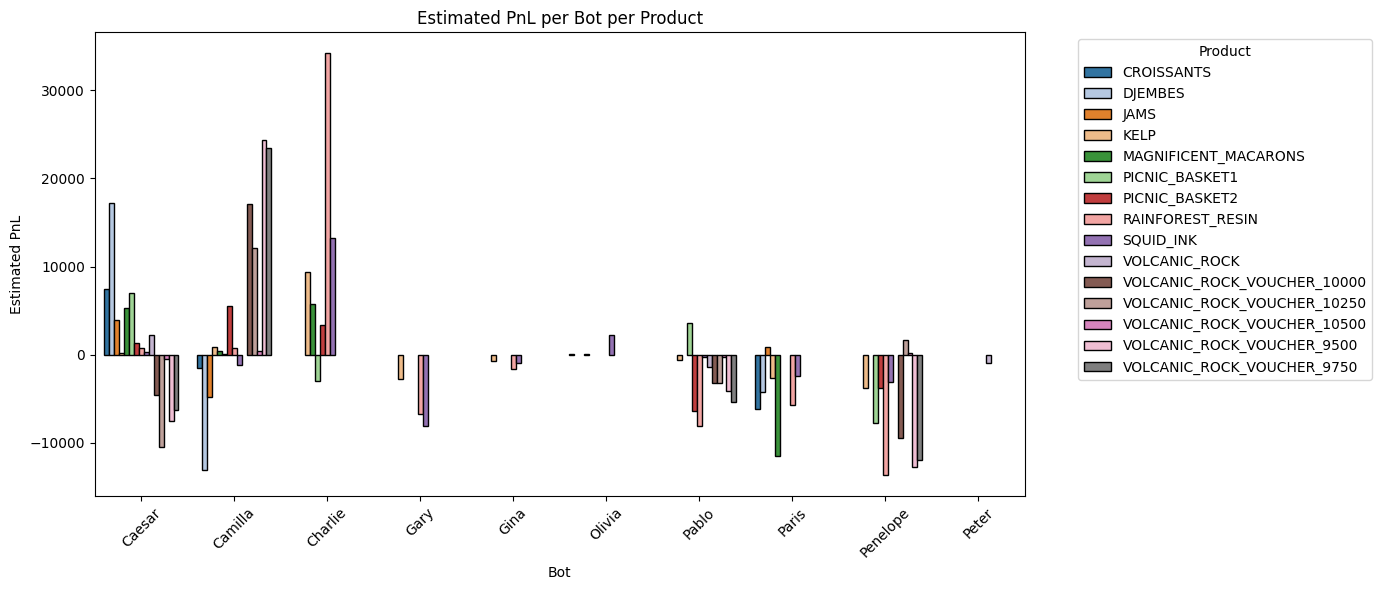

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bot_pnl_by_product(pnl_df):
    plt.figure(figsize=(14, 6))

    # Use a distinct and readable color palette
    unique_symbols = pnl_df['symbol'].unique()
    palette = sns.color_palette("tab20", n_colors=len(unique_symbols))
    color_map = {symbol: palette[i] for i, symbol in enumerate(unique_symbols)}

    # Draw the barplot
    ax = sns.barplot(
        data=pnl_df,
        x='bot',
        y='signed_pnl',
        hue='symbol',
        palette=color_map,
        edgecolor='black'  # Add edge to make bars more distinct
    )

    plt.xticks(rotation=45)
    plt.title("Estimated PnL per Bot per Product")
    plt.ylabel("Estimated PnL")
    plt.xlabel("Bot")
    plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_bot_pnl_by_product(pnl_per_bot)

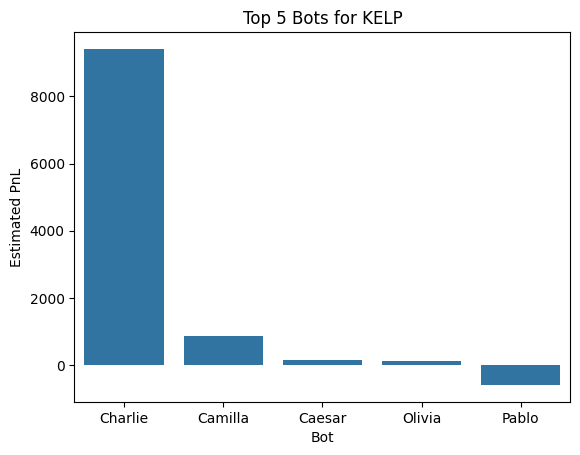

In [16]:
def plot_top_bots_for_product(pnl_df, product, top_n=5):
    df = pnl_df[pnl_df['symbol'] == product].sort_values('signed_pnl', ascending=False).head(top_n)
    sns.barplot(data=df, x='bot', y='signed_pnl')
    plt.title(f"Top {top_n} Bots for {product}")
    plt.ylabel("Estimated PnL")
    plt.xlabel("Bot")
    plt.show()

# Example
plot_top_bots_for_product(pnl_per_bot, "KELP")

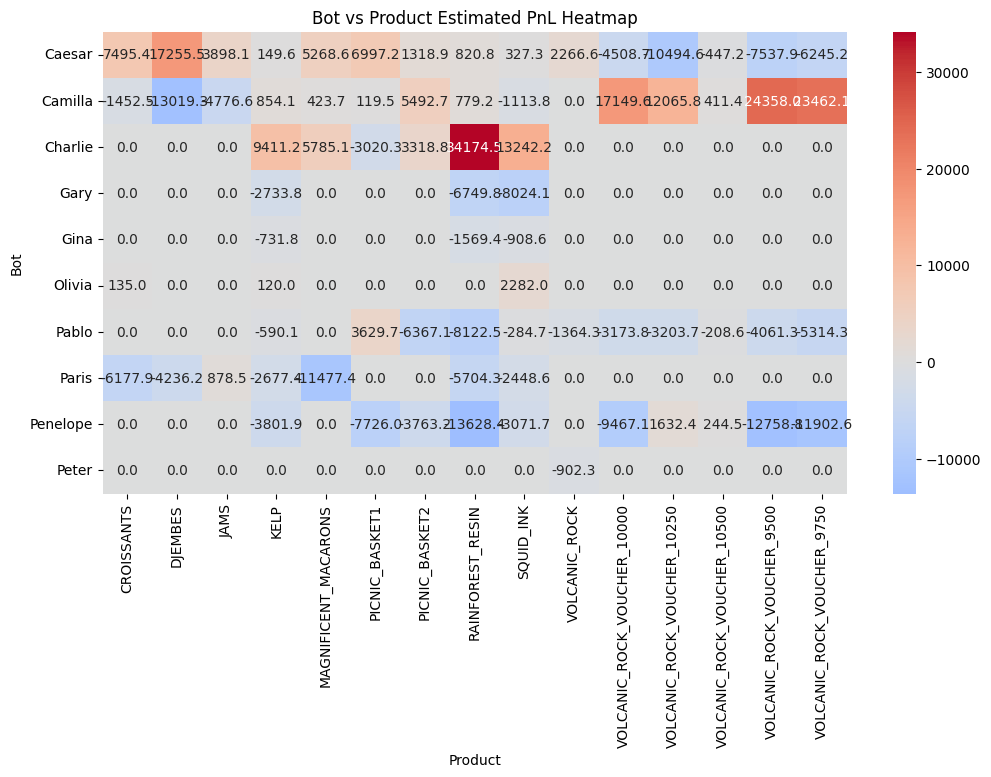

In [17]:
pivot = pnl_per_bot.pivot(index='bot', columns='symbol', values='signed_pnl').fillna(0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title("Bot vs Product Estimated PnL Heatmap")
plt.xlabel("Product")
plt.ylabel("Bot")
plt.show()

In [11]:
df['future_mid'] = df.groupby('symbol')['price'].shift(-3)  # 3 ticks in the future
df['price_change'] = df['future_mid'] - df['price']

# Separate buys/sells
buys = df[df['buyer'].notna()].copy()
sells = df[df['seller'].notna()].copy()

# Buy timing edge
buys['lead_edge'] = df['future_mid'] - df['price']
buy_leaders = buys.groupby(['buyer', 'symbol'])['lead_edge'].mean().reset_index().rename(columns={'buyer': 'bot'})

# Sell timing edge
sells['lead_edge'] = df['price'] - df['future_mid']
sell_leaders = sells.groupby(['seller', 'symbol'])['lead_edge'].mean().reset_index().rename(columns={'seller': 'bot'})

# display results
print("Buy timing edge:")
print(buy_leaders.sort_values('lead_edge', ascending=False).head(10))
print("Sell timing edge:")
print(sell_leaders.sort_values('lead_edge', ascending=False).head(10))

Buy timing edge:
        bot                symbol  lead_edge
31  Charlie      RAINFOREST_RESIN   5.794157
4    Caesar  MAGNIFICENT_MACARONS   5.353982
30  Charlie        PICNIC_BASKET2   4.284091
5    Caesar        PICNIC_BASKET1   4.131579
18  Camilla        PICNIC_BASKET1   3.905882
17  Camilla  MAGNIFICENT_MACARONS   2.735632
20  Camilla      RAINFOREST_RESIN   1.837838
7    Caesar      RAINFOREST_RESIN   1.714286
19  Camilla        PICNIC_BASKET2   1.534091
6    Caesar        PICNIC_BASKET2   1.500000
Sell timing edge:
        bot                symbol  lead_edge
43   Olivia             SQUID_INK  28.500000
5    Caesar        PICNIC_BASKET1   9.971429
20  Camilla        PICNIC_BASKET1   7.923810
30  Charlie  MAGNIFICENT_MACARONS   6.816667
31  Charlie        PICNIC_BASKET1   6.500000
33  Charlie      RAINFOREST_RESIN   5.712517
21  Camilla        PICNIC_BASKET2   5.055556
22  Camilla      RAINFOREST_RESIN   4.487805
6    Caesar        PICNIC_BASKET2   3.798077
32  Charlie        P

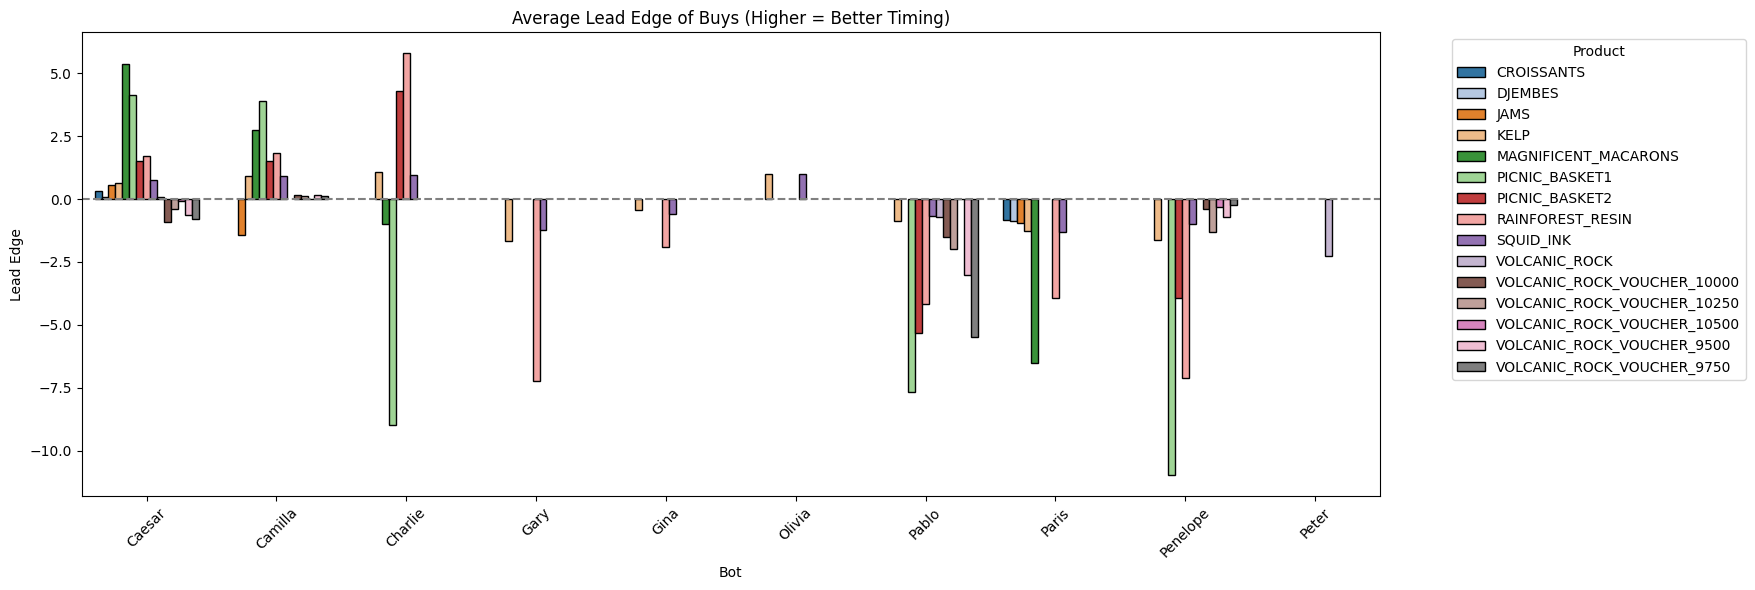

In [33]:
def plot_buy_lead_edge(buy_leaders):

    plt.figure(figsize=(14, 6))

    # Use a distinct and readable color palette
    unique_symbols = buy_leaders['symbol'].unique()
    palette = sns.color_palette("tab20", n_colors=len(unique_symbols))
    color_map = {symbol: palette[i] for i, symbol in enumerate(unique_symbols)}

    # Draw the barplot
    ax = sns.barplot(
        data=buy_leaders,
        x='bot',
        y='lead_edge',
        hue='symbol',
        palette=color_map,
        edgecolor='black'  # Add edge to make bars more distinct
    )

    plt.title("Average Lead Edge of Buys (Higher = Better Timing)")
    plt.ylabel("Lead Edge")
    plt.xlabel("Bot")
    plt.xticks(rotation=45)
    plt.axhline(0, linestyle='--', color='gray')
    plt.tight_layout()
    plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_buy_lead_edge(buy_leaders)

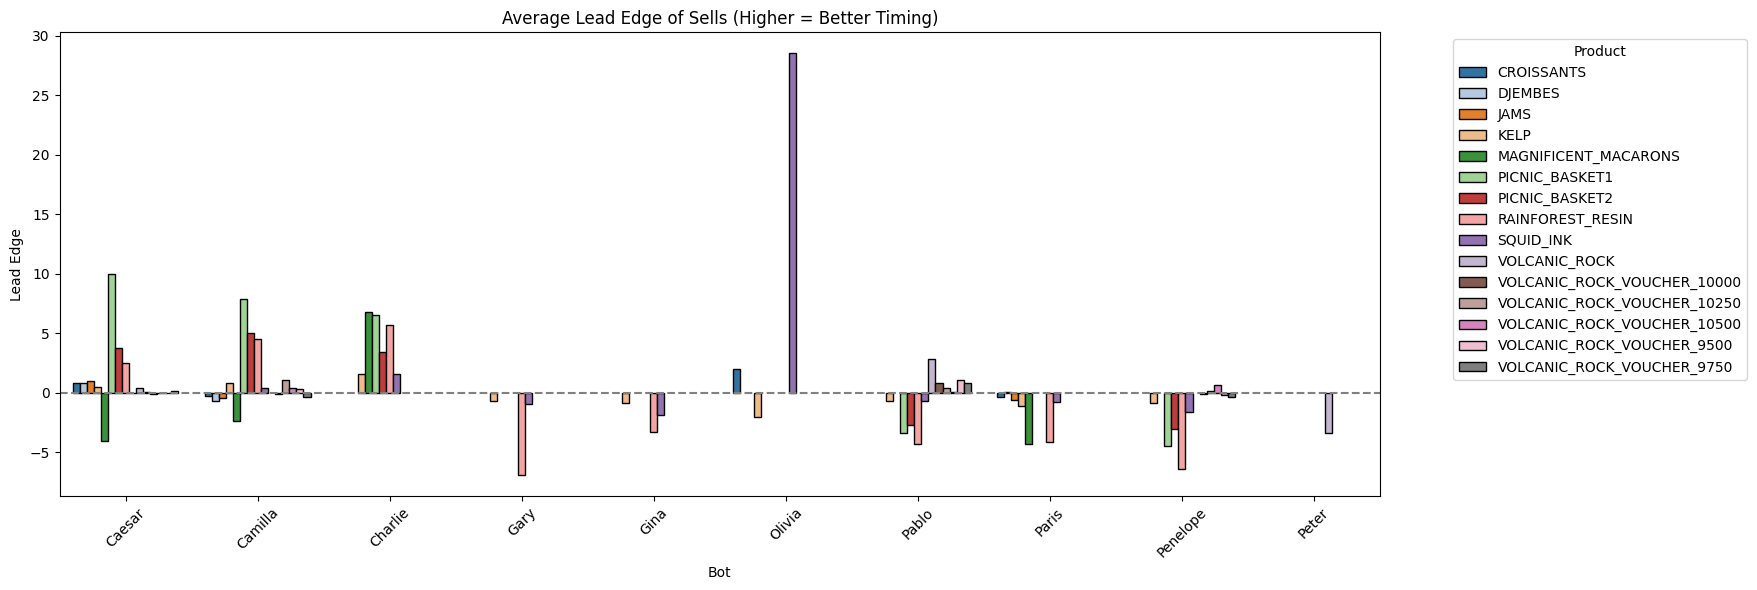

In [34]:
def plot_sell_lead_edge(sell_leaders):
    plt.figure(figsize=(14, 6))

    # Use a distinct and readable color palette
    unique_symbols = sell_leaders['symbol'].unique()
    palette = sns.color_palette("tab20", n_colors=len(unique_symbols))
    color_map = {symbol: palette[i] for i, symbol in enumerate(unique_symbols)}

    # Draw the barplot
    ax = sns.barplot(
        data=sell_leaders,
        x='bot',
        y='lead_edge',
        hue='symbol',
        palette=color_map,
        edgecolor='black'  # Add edge to make bars more distinct
    )


    plt.title("Average Lead Edge of Sells (Higher = Better Timing)")
    plt.ylabel("Lead Edge")
    plt.xlabel("Bot")
    plt.xticks(rotation=45)
    plt.axhline(0, linestyle='--', color='gray')
    plt.tight_layout()
    plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_sell_lead_edge(sell_leaders)

In [12]:
# Count how often they are buyer or seller
bot_activity = pd.concat([
    df[['buyer', 'symbol', 'quantity']].rename(columns={'buyer': 'bot'}),
    df[['seller', 'symbol', 'quantity']].rename(columns={'seller': 'bot'})
])

bot_counts = bot_activity.groupby(['bot', 'symbol']).size().reset_index(name='num_trades')

# display results
print("Bot activity counts:")
print(bot_counts.sort_values('num_trades', ascending=False).head(10))

Bot activity counts:
        bot            symbol  num_trades
34  Charlie         SQUID_INK        2027
29  Charlie              KELP        2000
58    Paris              KELP        1920
61    Paris         SQUID_INK        1901
33  Charlie  RAINFOREST_RESIN        1483
2    Caesar              JAMS        1149
9    Caesar     VOLCANIC_ROCK        1026
1    Caesar           DJEMBES        1016
0    Caesar        CROISSANTS         989
60    Paris  RAINFOREST_RESIN         951


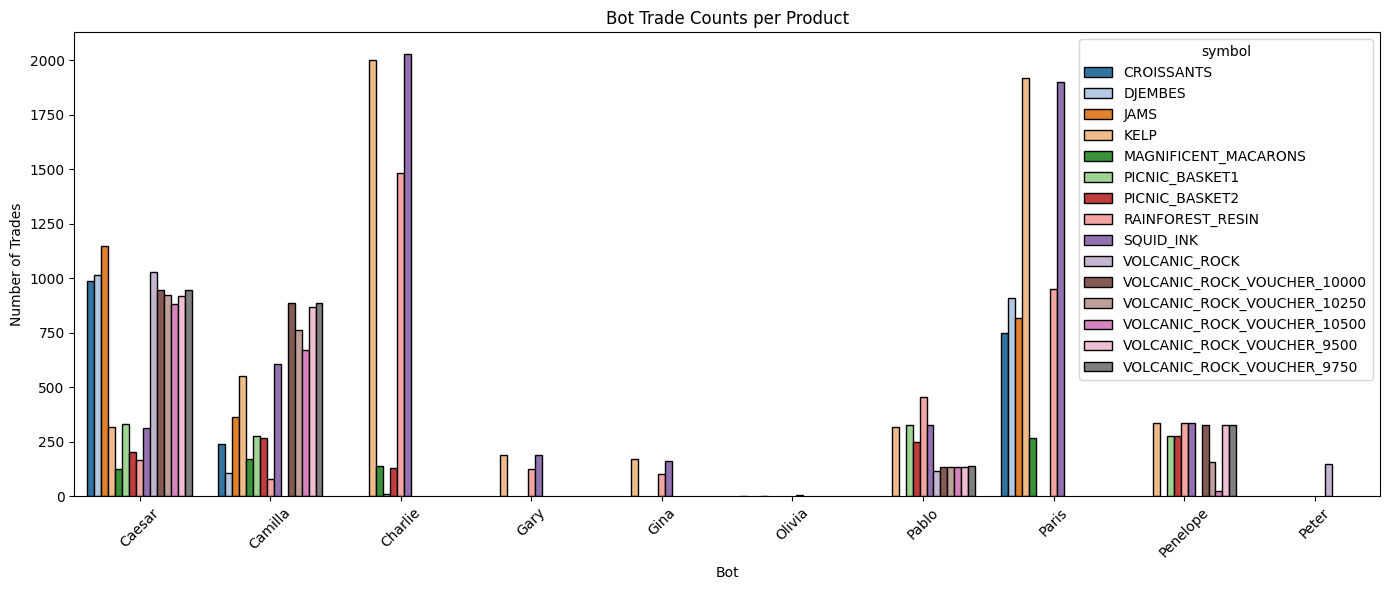

In [37]:
def plot_bot_activity(bot_counts):
    plt.figure(figsize=(14, 6))

    # Use a distinct and readable color palette
    unique_symbols = bot_counts['symbol'].unique()
    palette = sns.color_palette("tab20", n_colors=len(unique_symbols))
    color_map = {symbol: palette[i] for i, symbol in enumerate(unique_symbols)}

    # Draw the barplot
    ax = sns.barplot(
        data=bot_counts,
        x='bot',
        y='num_trades',
        hue='symbol',
        palette=color_map,
        edgecolor='black'  # Add edge to make bars more distinct
    )
    plt.title("Bot Trade Counts per Product")
    plt.ylabel("Number of Trades")
    plt.xlabel("Bot")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_bot_activity(bot_counts)

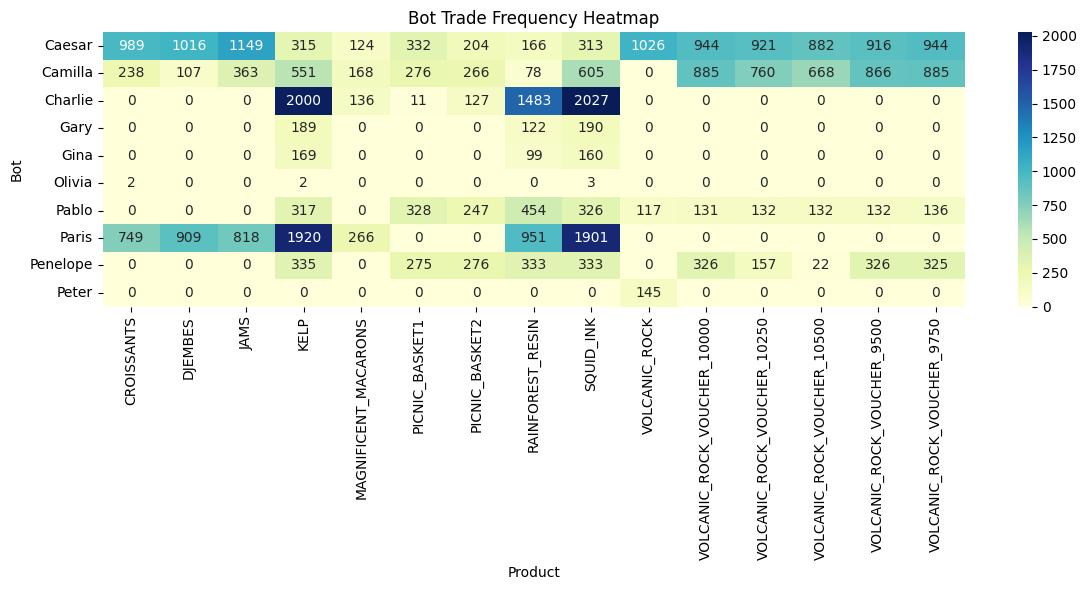

In [22]:
def plot_trade_frequency_heatmap(bot_counts):
    pivot = bot_counts.pivot(index='bot', columns='symbol', values='num_trades').fillna(0)
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Bot Trade Frequency Heatmap")
    plt.xlabel("Product")
    plt.ylabel("Bot")
    plt.tight_layout()
    plt.show()

plot_trade_frequency_heatmap(bot_counts)

In [ ]:
specialization = bot_activity.groupby('bot')['symbol'].nunique().reset_index(name="unique_products")
specialized_bots = specialization[specialization['unique_products'] <= 2]

# display results
print("Specialized bots (<= 2 products):")
print(specialized_bots.sort_values('unique_products').head(10))

Specialized bots (<= 2 products):
     bot  unique_products
9  Peter                1


In [43]:
# per product: rank bots by pnl, lead edges, and num_trades
def rank_bots_by_product(df, product):
    print(f"Ranking bots for product: {product}")
    # pnl
    pnl = estimate_pnl(df[df['symbol'] == product])
    pnl = pnl.sort_values('signed_pnl', ascending=False).reset_index(drop=True)
    pnl['rank_pnl'] = pnl.index + 1
    print("PnL ranking:")
    print(pnl[['bot', 'signed_pnl', 'rank_pnl']].head(10))

    # lead edge buy
    buy_lead = buy_leaders[buy_leaders['symbol'] == product]
    buy_lead = buy_lead.sort_values('lead_edge', ascending=False).reset_index(drop=True)
    buy_lead['rank_lead_buy'] = buy_lead.index + 1
    print("Buy lead edge ranking:")
    print(buy_lead[['bot', 'lead_edge', 'rank_lead_buy']].head(10))

    # lead edge sell
    sell_lead = sell_leaders[sell_leaders['symbol'] == product]
    sell_lead = sell_lead.sort_values('lead_edge', ascending=False).reset_index(drop=True)
    sell_lead['rank_lead_sell'] = sell_lead.index + 1
    print("Sell lead edge ranking:")
    print(sell_lead[['bot', 'lead_edge', 'rank_lead_sell']].head(10))

    # num trades
    num_trades = bot_counts[bot_counts['symbol'] == product]
    num_trades = num_trades.sort_values('num_trades', ascending=False).reset_index(drop=True)
    num_trades['rank_num_trades'] = num_trades.index + 1
    print("Trade count ranking:")
    print(num_trades[['bot', 'num_trades', 'rank_num_trades']].head(10))

In [44]:
# use this function to rank bots for each product
products = df['symbol'].unique()
for product in products:
    rank_bots_by_product(df, product)

Ranking bots for product: CROISSANTS
PnL ranking:
       bot   signed_pnl  rank_pnl
0   Caesar  7495.413549         1
1   Olivia   135.000000         2
2  Camilla -1452.529828         3
3    Paris -6177.883721         4
Buy lead edge ranking:
      bot  lead_edge  rank_lead_buy
0  Caesar   0.315625              1
1  Olivia   0.000000              2
2   Paris  -0.817391              3
Sell lead edge ranking:
       bot  lead_edge  rank_lead_sell
0   Olivia   2.000000               1
1   Caesar   0.815029               2
2  Camilla  -0.247899               3
3    Paris  -0.361596               4
Trade count ranking:
       bot  num_trades  rank_num_trades
0   Caesar         989                1
1    Paris         749                2
2  Camilla         238                3
3   Olivia           2                4
Ranking bots for product: RAINFOREST_RESIN
PnL ranking:
        bot    signed_pnl  rank_pnl
0   Charlie  34174.450895         1
1    Caesar    820.756918         2
2   Camilla   